## NDVI time series

In [97]:
import planetary_computer
from pystac_client import Client
import stackstac
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import time

In [108]:
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record start time
        result = func(*args, **kwargs)
        end_time = time.time()    # Record end time
        print(f"Function '{func.__name__}' executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

In [109]:
def epsg_str_to_int(epsg_str: str = 'EPSG:4362') -> int:
    """
    Converts the EPSG from string to integer
    
    Args:
        epsg_str (str): EPSG of the form EPSG:<code>
    
    Returns:
        int
    """
    return int(epsg_str.split(':')[1])

In the `main` function it would make sense to modify the `cloud_cover` and the buffer size of `buffered_geom`.  
You can also play with the `start_date`, `end_date` and `coords`.  

In [111]:
@timing_decorator
def main(start_date: str = "yyyy-mm-dd", end_date: str = "yyyy-mm-dd", coords: tuple = (float, float)) -> tuple:
    """
    Args:
        start_date (str): start date
        end_date (str): end date
        coords (tuple): latitude (float), longitude (float)
    
    Returns:
        tuple: ndvi_mean (np.array), ndvi_time (np.array)
    """
    # # Coordinates and time range
    # lat, lon = 2.32738, 41.61884  # Replace with your coordinate
    # start_date = "2020-01-01"
    # end_date = "2025-12-30"

    # Create a GeoDataFrame for your point
    gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")
    # Connect to MPC STAC API
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # Search Sentinel-2 Level 2A imagery
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=gdf.geometry[0],
        datetime=f"{start_date}/{end_date}",
        query={"eo:cloud_cover": {"lt": 40}},
    )
    items = list(search.items())
    
    # Sign the items for Planetary Computer access
    signed_items = [planetary_computer.sign(item) for item in items]  # take first for simplicity
    
    # Derive target epsg as integer
    epsg_int = epsg_str_to_int(items[0].properties['proj:code'])
    buffered_geom = gdf.to_crs(epsg=epsg_int).buffer(1).to_crs(epsg=4326) # the buffer size can be modified as you wish
    
    stack = stackstac.stack(
    signed_items,
    assets=["B04", "B08"],  # Red and NIR bands for NDVI
    epsg=epsg_int, 
    resolution=10,
    bounds_latlon=buffered_geom.total_bounds,
    chunksize=4096,
    )

    # Select Red and NIR
    red = stack.sel(band="B04").astype("float32")
    nir = stack.sel(band="B08").astype("float32")
    
    ndvi = (nir - red) / (nir + red)
    ndvi_mean_xr = ndvi.mean(dim=["x", "y"]).compute()  # average at that location
    # Get time and ndvi values
    ndvi_mean = ndvi_mean_xr.values
    ndvi_time = ndvi_mean_xr.time.values
    
    return ndvi_mean, ndvi_time

In [111]:
# Run example
coords = 2.32738, 41.61884  # Replace with your coordinate
start_date = "2024-01-01"
end_date = "2025-12-30"

ndvi_mean, ndvi_time = main(start_date, end_date, coords)

Function 'main' executed in 9.4189 seconds


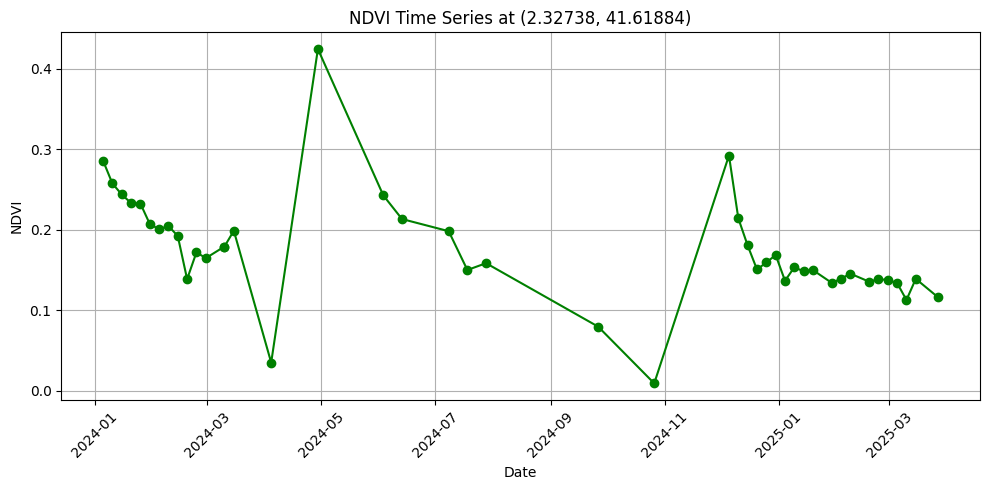

In [113]:
plt.figure(figsize=(10, 5))
plt.plot(ndvi_time, ndvi_mean, marker='o', linestyle='-', color='green')
plt.title("NDVI Time Series at ({}, {})".format(lat, lon))
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In the code below you can execute each step of the above function interactively.

In [83]:
# Coordinates and time range
lat, lon = 2.32738, 41.61884  # Replace with your coordinate
start_date = "2020-01-01"
end_date = "2025-12-30"

# Create a GeoDataFrame for your point
gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs="EPSG:4326")

In [84]:
# bounds_modified = np.array([gdf.total_bounds[0] - 0.01, gdf.total_bounds[1] - 0.01, gdf.total_bounds[2] + 0.01, gdf.total_bounds[3] + 0.01])

In [85]:
# gdf.total_bounds

In [86]:
# Connect to MPC STAC API
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Search Sentinel-2 Level 2A imagery
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=gdf.geometry[0],
    datetime=f"{start_date}/{end_date}",
    query={"eo:cloud_cover": {"lt": 40}},
)

items = list(search.items())
print(f"Found {len(items)} items")

Found 202 items


In [87]:
# Sign the items for Planetary Computer access
signed_items = [planetary_computer.sign(item) for item in items]  # take first for simplicity

In [88]:
# for i in signed_items:
#     print(i.properties['proj:code'])

In [89]:
buffered_geom = gdf.to_crs(epsg=32610).buffer(1).to_crs(epsg=4326)
buffered_geom, buffered_geom.total_bounds

(0    POLYGON ((41.61883 2.32738, 41.61883 2.32738, ...
 dtype: geometry,
 array([41.61883133,  2.32737128, 41.61884867,  2.32738872]))

In [90]:
# bounds_modified = np.array([gdf.total_bounds[0] - 0.01, gdf.total_bounds[1] - 0.01, gdf.total_bounds[2] + 0.01, gdf.total_bounds[3] + 0.01])
# bounds_modified, gdf.total_bounds

In [91]:
# Load data using stackstac
stack = stackstac.stack(
    signed_items,
    assets=["B04", "B08"],  # Red and NIR bands for NDVI
    epsg=32610,
    resolution=10,
    bounds_latlon=buffered_geom.total_bounds,
    chunksize=4096,
)

# Select Red and NIR
red = stack.sel(band="B04").astype("float32")
nir = stack.sel(band="B08").astype("float32")

In [92]:
ndvi = (nir - red) / (nir + red)
ndvi_mean_xr = ndvi.mean(dim=["x", "y"]).compute()  # average at that location
# print("NDVI:", ndvi_mean)

In [93]:
# ndvi_mean_xr.values

In [94]:
# ndvi_mean_xr.time.values

In [95]:
# Get time and ndvi values
ndvi_mean = ndvi_mean_xr.values
ndvi_time = ndvi_mean_xr.time.values

In [114]:
ndvi.isel(time=10).plot(cmap="YlGn")
plt.title("NDVI")
plt.show()

RuntimeError: Error opening 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/37/N/GC/2020/02/25/S2B_MSIL2A_20200225T072859_N0212_R049_T37NGC_20200928T084433.SAFE/GRANULE/L2A_T37NGC_A015519_20200225T073829/IMG_DATA/R10m/T37NGC_20200225T072859_B04_10m.tif?st=2025-05-13T10%3A57%3A29Z&se=2025-05-14T11%3A42%3A29Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-05-14T09%3A50%3A51Z&ske=2025-05-21T09%3A50%3A51Z&sks=b&skv=2024-05-04&sig=wdLh6zFmFeBoGUAjzEDCcc8AjJB6ihEwTIFo7Xt83Ss%3D': RasterioIOError("'/vsicurl/https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/37/N/GC/2020/02/25/S2B_MSIL2A_20200225T072859_N0212_R049_T37NGC_20200928T084433.SAFE/GRANULE/L2A_T37NGC_A015519_20200225T073829/IMG_DATA/R10m/T37NGC_20200225T072859_B04_10m.tif?st=2025-05-13T10%3A57%3A29Z&se=2025-05-14T11%3A42%3A29Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-05-14T09%3A50%3A51Z&ske=2025-05-21T09%3A50%3A51Z&sks=b&skv=2024-05-04&sig=wdLh6zFmFeBoGUAjzEDCcc8AjJB6ihEwTIFo7Xt83Ss%3D' not recognized as being in a supported file format.")